<a href="https://colab.research.google.com/github/Sejong-Kaggle-Challengers/jeongmin/blob/main/NLP_baseline_%2B_stopwords_(%EC%84%B1%EB%8A%A5_%EB%8D%94_%EB%96%A8%EC%96%B4%EC%A7%90).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

Uninstalling kaggle-1.5.10:
  Successfully uninstalled kaggle-1.5.10
     |████████████████████████████████| 1.5MB 8.4MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 2.7 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=78df0928f720d68f37469fd3ffa51c3c6a015491aac7585987ea11098c45ebba
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle -v

Kaggle API 1.5.6


In [ ]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 49.3MB/s]


In [ ]:
!unzip nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


Columns
- id - a unique identifier for each tweet
- text - 트윗의 text
- location -트윗을 보낸 위치 (may be blank)
- keyword - 트윗의 특정 키워드 (may be blank)
- target - (in train.csv only), this denotes whether a tweet is about a real disaster (1) or not (0) 
실제 재난을 나타내는지 아닌지

https://www.kaggle.com/philculliton/nlp-getting-started-tutorial

In [ ]:
import numpy as np
import pandas as pd
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


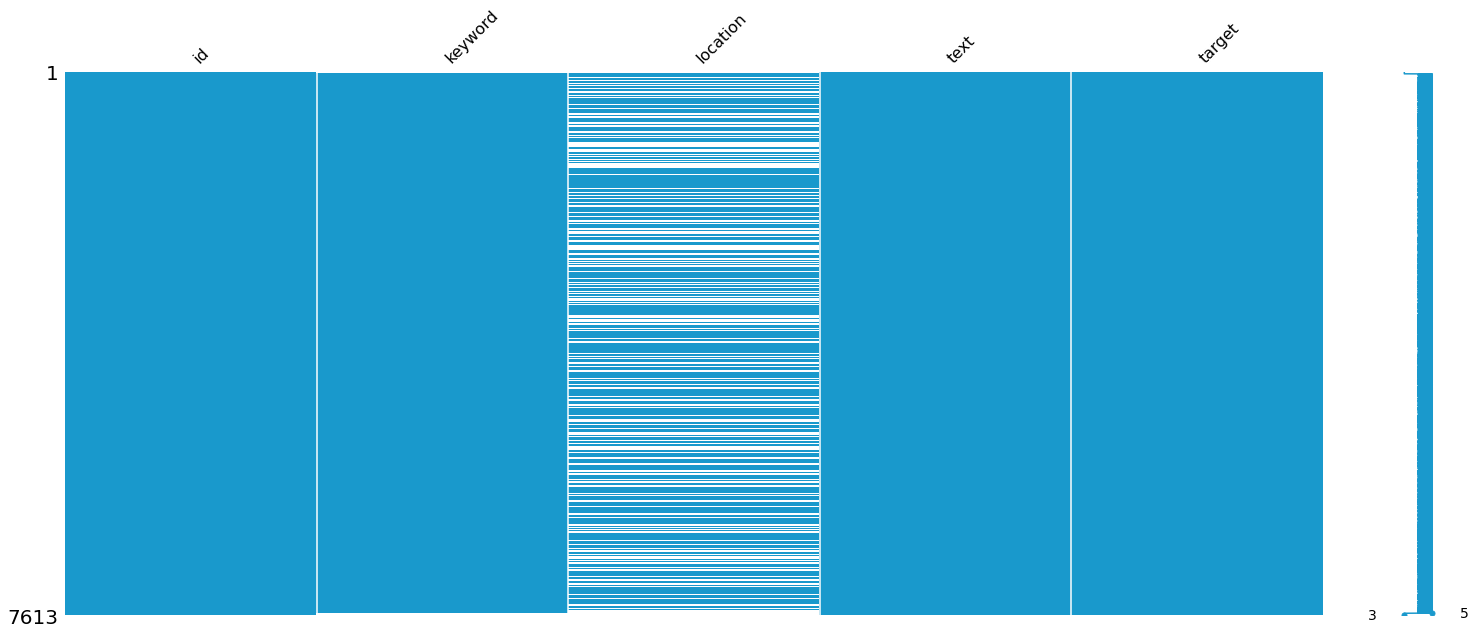

In [ ]:
import missingno as msno # 결측치 확인

msno.matrix(df=train_df.iloc[:, :], color=(0.1, 0.6, 0.8))
#keyword 부분 --> 위 아래 부분이 결측인 듯

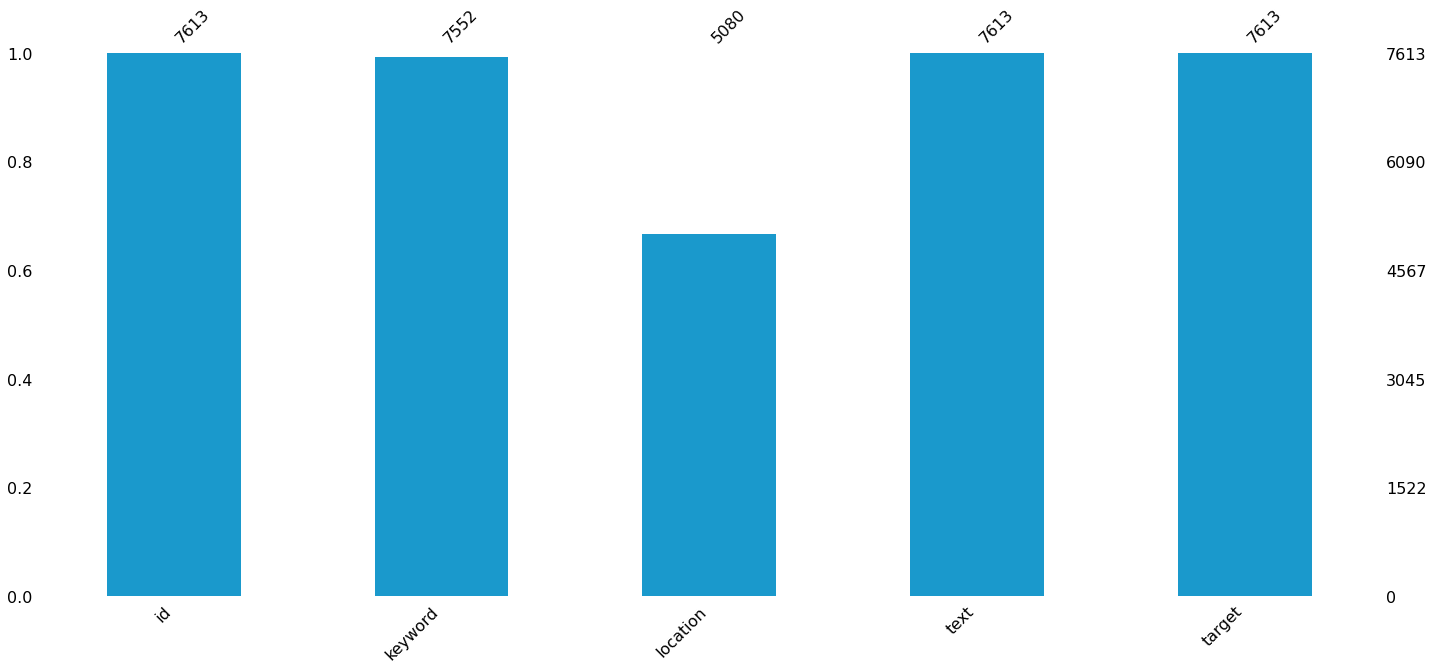

In [ ]:
msno.bar(df=train_df.iloc[:, :], color=(0.1, 0.6, 0.8))

A quick look at our data
Let's look at our data... first, an example of what is NOT a disaster tweet.

In [ ]:
train_df[train_df["target"] == 0]["text"].values[1]

'I love fruits'

In [ ]:
train_df[train_df["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

In [ ]:
import nltk
nltk.download('stopwords') #nltk의 불용어 리스트 데이터 설치
nltk.download('punkt') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm

stop_words = list(stopwords.words('english'))
i = 0
for text in tqdm(train_df["text"]):
  tok = word_tokenize(text)
  result = []
  for word in tok :
    if word not in stop_words:
      result.append(word)
  train_df["text"][i] = ' '.join(result)
  i+=1


  0%|          | 0/7613 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
100%|██████████| 7613/7613 [00:04<00:00, 1684.50it/s]


In [ ]:
train_df['text']

0       Our Deeds Reason # earthquake May ALLAH Forgiv...
1                 Forest fire near La Ronge Sask . Canada
2       All residents asked 'shelter place ' notified ...
3       13,000 people receive # wildfires evacuation o...
4       Just got sent photo Ruby # Alaska smoke # wild...
                              ...                        
7608    Two giant cranes holding bridge collapse nearb...
7609    @ aria_ahrary @ TheTawniest The control wild f...
7610    M1.94 [ 01:04 UTC ] ? 5km S Volcano Hawaii . h...
7611    Police investigating e-bike collided car Littl...
7612    The Latest : More Homes Razed Northern Califor...
Name: text, Length: 7613, dtype: object

scikit-learn의 CountVectorizer를 통해 각 트윗의 단어를 세어서 머신러닝 모델이 처리할 수 있는 데이터로 만든다.

In [ ]:
train_df["text"][0:5]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [ ]:
count_vectorizer = feature_extraction.text.CountVectorizer()

## let's get counts for the first 5 tweets in the data
#example_train_vectors = count_vectorizer.fit_transform(train_df["text"][0:5])

In [ ]:
## we use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

(1, 54)
[[0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0]]


In [ ]:
train_vectors = count_vectorizer.fit_transform(train_df["text"])
test_vectors = count_vectorizer.transform(test_df["text"])

##Model 
- linear model
- 교차 검증 사용 (측정 기준 : F1)

In [ ]:
clf = linear_model.RidgeClassifier()

In [ ]:
scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=5, scoring="f1")
scores

array([0.5972093 , 0.49531915, 0.56373713, 0.5210084 , 0.66302652])

In [ ]:
clf.fit(train_vectors, train_df["target"])

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)

In [ ]:
sample_submission = pd.read_csv("sample_submission.csv")

In [ ]:
sample_submission["target"] = clf.predict(test_vectors)

In [ ]:
sample_submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [ ]:
sample_submission.to_csv("submission.csv", index=False)

In [ ]:
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "baseline + stopwords"

100% 22.2k/22.2k [00:02<00:00, 8.38kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets